# Hyperparameteroptimization

https://towardsdatascience.com/bayesian-optimization-with-python-85c66df711ec 

Steps:
   1. Definition of the data
   2. Definition of the hyperparameter space
   3. Loop over all different combinations of the hyperparamter space
       1. Define the model with the hyperparameters
       2. Optimize model (learning phase)
       3. Evaluate model and store metric with the parameters
 

## 0. Imports & utils

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

import timeit

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import itertools

from mpl_toolkits import mplot3d


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import time, sys
from IPython.display import clear_output

import pysgpp

from bayes_opt import BayesianOptimization, UtilityFunction


def update_progress(progress, time, remaining_time):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    text += "\nCurrent time per iteration: " + str(time)
    text += "\nApprox. time remaining: " + str(remaining_time)
    print(text)

    
def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

## 1. Definition of Data

In [10]:
NORMAL_FILE_PATH = "ecg/normal"
ABNORMAL_FILE_PATH = "ecg/abnormal"

SPLIT_RATIO = 0.8

# Load the .0 and .1 files as integer and with max 75 elements per entry.
normal_data = np.array([[np.loadtxt(entry, dtype=int, usecols=1, max_rows=75)] for entry in os.scandir(NORMAL_FILE_PATH) if not entry.name.endswith(".ann")], dtype=object)
abnormal_data = np.array([[np.loadtxt(entry, dtype=int, usecols=1, max_rows=75)] for entry in os.scandir(ABNORMAL_FILE_PATH) if not entry.name.endswith(".ann")], dtype=object)

# Pad the with zeroes, so that each entry has 75 data points. Also append the class number at the end (0=normal, 1=abnormal).
normal_data = np.array([np.append(np.pad(d[0], pad_width=(0, 75 - len(d[0]))), 0) for d in normal_data])
abnormal_data = np.array([np.append(np.pad(d[0], pad_width=(0, 75 - len(d[0]))), 1) for d in abnormal_data])

# Combine the normal and abnormal data and shuffle the whole dataset.
combined_data = np.concatenate((normal_data, abnormal_data))
np.random.shuffle(combined_data)

# Split into training and validation sets.
X_train = torch.Tensor(combined_data[:int(len(combined_data) * SPLIT_RATIO), 0:75])
X_test = torch.Tensor(combined_data[int(len(combined_data) * SPLIT_RATIO):, 0:75])
Y_train = torch.Tensor(combined_data[:int(len(combined_data) * SPLIT_RATIO), 75:])
Y_test = torch.Tensor(combined_data[int(len(combined_data) * SPLIT_RATIO):, 75:])

print("Number of Training samples: ", len(X_train))
print("Number of Testing samples: ", len(X_test))

Number of Training samples:  320
Number of Testing samples:  80


## 2. Definition of Hyperparameter space

In [11]:
hyperparameters = {
    "learning_rate" : [0.00001, 0.01],
    "epochs" : [1, 300]
}

print("Number of hyperparameters: ", len(hyperparameters))

Number of hyperparameters:  2


## 3. Loop over combinations

In [12]:
def black_box_function(learning_rate, epochs):
        
    # Create neural network with 3 layers (75, 5, 1).
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(75, 15)
            self.fc2 = nn.Linear(15, 1)

        def forward(self, x):
            x = self.fc1(x)
            x = F.relu(x)
            x = self.fc2(x)
            x = torch.sigmoid(x)
            return x

    # Set optimizer and loss function.
    n = Net()
    #optimizer = optim.RMSprop(n.parameters(), lr=0.001)
    optimizer = optim.RMSprop(n.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCELoss()
    #epochs = 300
    t_loss = []
    v_loss = []
    t_acc = []
    v_acc = []


    def avg(l):
        return sum(l) / len(l)

    # Training
    for i in range(int(epochs)):
        n.train()
        y_pred_train = n(X_train)
        loss_train = loss_fn(y_pred_train, Y_train)
        y_pred_test = n(X_test)
        loss_test = loss_fn(y_pred_test, Y_test)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        n.eval()
        t_loss.append(loss_train.item())
        v_loss.append(loss_test.item())
        predictions_test = [round(i[0]) for i in y_pred_test.tolist()]
        accuracy_test = Y_test.tolist()
        acc_test = avg([1 - (abs(predictions_test[i] - accuracy_test[i][0])) for i in
                        range(len(accuracy_test))])
        predictions_train = [round(i[0]) for i in y_pred_train.tolist()]
        accuracy_train = Y_train.tolist()
        acc_train = avg([1 - (abs(predictions_train[i] - accuracy_train[i][0])) for i in
                         range(len(accuracy_train))])
        t_acc.append(acc_train)
        v_acc.append(acc_test)
    
    #return max(v_acc)
    return v_acc[-1]

    
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = hyperparameters, verbose = 2,
                                 random_state = 4)

# optimizer.maximize(init_points = 5, n_iter = 200)

utility = UtilityFunction(kind = "ucb", kappa = 1.96, xi = 0.01)

time = 0
number_iterations = 100
for i in range(number_iterations):
    
    starttime = timeit.default_timer()
    
    # Get optimizer to suggest new parameter values to try using the
    # specified acquisition function.
    next_point = optimizer.suggest(utility)    # Force degree from float to int.
    
    # the new parameter values.
    target = black_box_function(**next_point)    
    try:
        # Update the optimizer with the evaluation results. 
        # This should be in try-except to catch any errors!
        optimizer.register(params = next_point, target = target)
    except:
        pass
    
    percentage = (i+1)/number_iterations

    endtime = timeit.default_timer()
    time += (endtime-starttime)
    
    remaining_time_prediction = (time/(i+1))*number_iterations - time
    
    update_progress(percentage, (endtime-starttime), remaining_time_prediction)
    

print("Iterations took ", time, " seconds.")

Progress: [####################] 100.0%
Current time per iteration: 0.39639617700004237
Approx. time remaining: 0.0
Iterations took  24.4387550140018  seconds.


## 4. Plotting and Result

Best result: {'epochs': 288.99717416848057, 'learning_rate': 0.006119927564262396}; f(x) = 0.912.


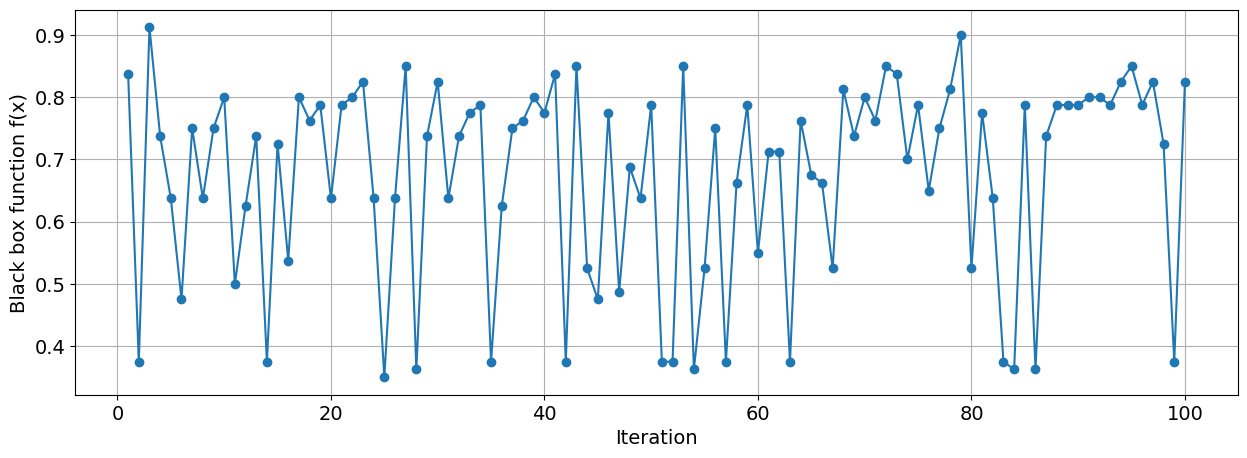

In [13]:
print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))

plt.figure(figsize = (15, 5))
plt.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, "-o")
plt.grid(True)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Black box function f(x)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()